# Calculate metrics using climpred

---

Now that all of our model and observational data is ready for analysis, we can run this notebook and calculate various metrics using climpred across all models and seasons and compare how they do. It is recommended that you use `dask` to run this notebook as we are looking at geospatial data and making maps. You can start up a `dask` cluster by running the notebook `cluster.ipynb` and copying the Scheduler tcp number into this notebook.

In [1]:
import cftime
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import climpred
import intake
from tqdm import tqdm
import dask.array as da
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import xskillscore as xs
import warnings
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

- Make sure you have copied the correct tcp here from the `cluster.ipynb` notebook

In [2]:
client = Client("tcp://10.12.206.60:35309")

## Here is where you choose your variable, metric and start/end time.

In [3]:
variable = "t2m" #can be t2m, tp, gh_500
metric = "acc" #can be rps, rmse, acc
data = "anom"
lead = "biweekly" #biweekly or daily
area = "geospatial"
start = "1999-01-01"
end = "2015-12-31" 
models = ["ECMWF","NCEP","CESM2"] #this notebook uses all three of these models

In [4]:
# Here we are just setting options for the different metrics and mapping.
if metric == "acc":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="RdBu_r" #options for maps
elif metric=="rmse":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="viridis" #options for maps
elif metric=="rps":
    comp="m2o"; dim=["init","member"]; ens="" #options for metrics
    cmap="viridis" #options for maps

## Now we read in and load the data into `dask`

We are using the intake catalog to find the data and load it up. Make sure you have the file `ASP_data_catalog.yml` in your local directory. Or you can find it here: `/glade/campaign/mmm/c3we/jaye/S2S_zarr/`

We have an `if` statement here telling us to load in category_edge files, only if our metric of choice is `rps`

In [5]:
cat = intake.open_catalog('/glade/u/home/jaye/ASP_github/ASP_data_catalog.yml')

In [6]:
hinds = {}
for m in models:
    hinds[m] = cat[m](data=data, lead=lead, dim=area).to_dask().astype('float32')
verif = cat['OBS'](data=data, lead=lead, dim=area).to_dask().astype('float32')

In [7]:
if metric == "rps":
    hinds_edges = {}
    for m in models:
        hinds_edges[m] = cat['cat_edges'](data=data, model=m, lead=lead, dim=area).to_dask().astype('float32') \
                         .chunk({"category_edge": -1, "dayofyear": -1, "lat": 45, "lead": -1, "lon": 60}).persist()
    verif_edges = cat['cat_edges'](data='anom', model='OBS', lead='biweekly', dim='geospatial').to_dask().astype('float32') \
                  .chunk({"category_edge": -1, "dayofyear": -1, "lat": 45, "lon": 60}).persist()

- All of the model data is now loaded into a dictionary so that we can have them all together for comparison purposes.

In [8]:
# is seasonal data available for all models and rechunk
for h in hinds:
    print(hinds[h].init.dt.season.to_index().unique(), 'freq =',hinds[h].init.to_index().freq) # freq would show weekly but calendar conversion breaks this
    hinds[h] = hinds[h].chunk({"member": "auto", "init": -1, "lead": "auto", "lat": 45, "lon": 60}).persist()
    hinds[h] = hinds[h].sel(init=slice(start,end))
    hinds[h] = hinds[h].where(-88.6<hinds[h].lat)
    hinds[h] = hinds[h].where(88.6>hinds[h].lat)
verif = verif.sel(time=slice(start,end))
if data=="raw":
    verif = verif.chunk({"time": -1, "lat": 45, "lon": 60})+273.15
else:
    verif = verif.chunk({"time": -1, "lat": 45, "lon": 60})

Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None
Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None
Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None


In [9]:
lmask = np.isnan(verif.t2m[0,:,:]) # making a landmask from the CPC data
lmask = lmask.drop(["time"])

## Create a Hindcast Ensemble in climpred for each of the models and run metrics

We are also setting kwargs (options) for `verify` in climpred. The second cell does the metric calculation using `verify` and computes it. Finally all models are concatenated together and plotted.

This could take a few minutes to run. If you are curious, check out the `dask` dashboard and you can watch the progress of the computations. The link should be like this: `https://jupyterhub.hpc.ucar.edu/stable/user/jaye/proxy/37030/status`. The number between proxy and status will vary. Your link will be available where you started your dask cluster in `cluster.ipynb`

In [10]:
he = {}
met = {}
for h in hinds:
    print(h)
    he[h] = climpred.HindcastEnsemble(hinds[h]).add_observations(verif)
    if metric=="rps":
        metric_kwargs = dict(metric=metric, comparison=comp, dim=dim, alignment="same_inits")
        met[h] = he[h].verify(category_edges=(verif_edges, hinds_edges[h]),**metric_kwargs)
    else:
        metric_kwargs = dict(metric=metric, comparison=comp, dim=dim, alignment="same_inits", skipna=True)
        met[h] = he[h].verify(**metric_kwargs)
    met[h] = met[h].compute()

ECMWF
NCEP
CESM2


In [11]:
met_all = xr.concat([met[models[0]], met[models[1]], met[models[2]]], dim='model') \
          .assign_coords(model=[models[0], models[1], models[2]])

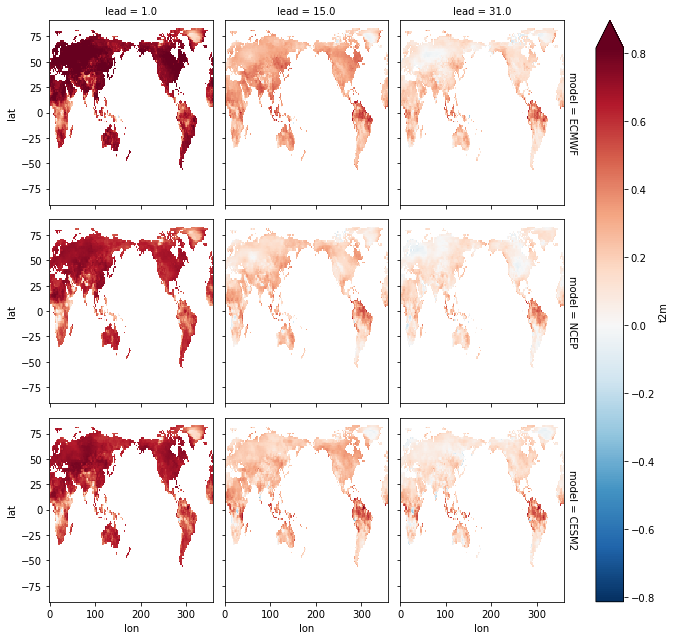

In [12]:
met_all[variable].plot(col='lead',row='model',cmap=cmap,robust=True)

## Seasonal data

Now we will create seasonal averages of the data. Prior to this we have been looking at annual data. We use `groupby` here to group into seasons and then run `verify` over each of the seasons and models for the metric of our choice. They are then concatenated together and plotted for `lead=15` (weeks 3-4).

In [13]:
groupby = "season"
met_seas = {}
for h in hinds:
    met_groups = []
    label_groups = []
    # Loops through all inits for a given season.
    for label_group, group in tqdm(he[h].get_initialized().groupby(f"init.{groupby}")):
        # select only season inits
        if metric=="rps":
            met_group = he[h].sel(init=group.init).verify(category_edges=(verif_edges, hinds_edges[h]),**metric_kwargs)
        else:
            met_group = he[h].sel(init=group.init).verify(**metric_kwargs)
        met_groups.append(met_group)
        label_groups.append(label_group)
    met_groups = xr.concat(met_groups, dim=groupby).assign_coords(season=label_groups)
    met_seas[h] = met_groups.compute()

100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


In [14]:
met_seas_all = xr.concat([met_seas[models[0]], met_seas[models[1]], met_seas[models[2]]], dim='model') \
               .assign_coords(model=[models[0], models[1], models[2]])

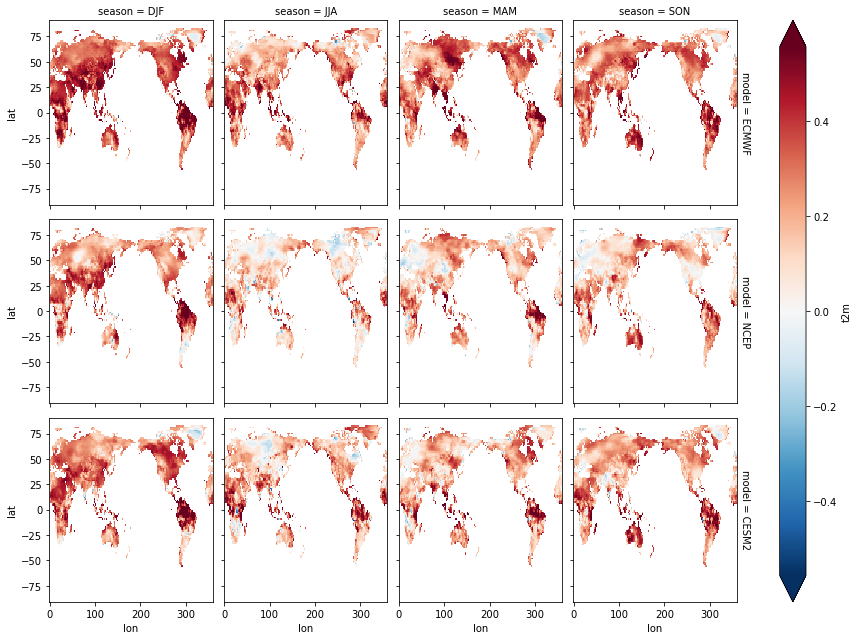

In [15]:
met_seas_all.sel(lead=15)[variable].plot(col=groupby, row='model', robust=True)

## Area weighting

Next we run cosine area weighting over that data to get a weighted lat/lon average over the domain. We then print out the weights and plot them on bar charts to compare different seasons and models.

In [16]:
#sashas orig
def area_weight(met,lat):
    MET0 = met
    MET0 = MET0.where(lmask==False)
    MET0 = MET0.where(np.isfinite(MET0))
    METzm = np.nanmean(MET0,axis=1)
    nanmask=~np.isnan(METzm)
    met_new = np.nansum(METzm*np.cos(np.deg2rad(lat)))/np.nansum(nanmask*np.cos(np.deg2rad(lat)))
    dm = xr.DataArray(met_new)
    return(dm)

In [17]:
season_all = []
for i in met_seas_all.lead: # model
    model_all = []
    for j in met_seas_all.season: # season
        model = []
        for k in met_seas_all.model: # lead
            da = area_weight(met_seas_all[variable].sel(lead=i,season=j,model=k).squeeze(),met_seas_all.lat)
            model.append(da)
        modela = xr.concat(model,dim="model",).assign_coords(model=[models[0], models[1], models[2]])
        model_all.append(modela)
    seasona = xr.concat(model_all,dim="season").assign_coords(season=["DJF","JJA","MAM","SON"])
    season_all.append(seasona)
weight2 = xr.concat(season_all,dim="lead").assign_coords(lead=[1.0,15.0,31.0]).transpose("model","season","lead")

In [18]:
weight2

<xarray.DataArray (model: 3, season: 4, lead: 3)>
array([[[0.69009675, 0.35249778, 0.2080487 ],
        [0.60586042, 0.2605427 , 0.16012333],
        [0.63648293, 0.28992238, 0.19366421],
        [0.63644922, 0.296023  , 0.18434395]],

       [[0.60355533, 0.2454573 , 0.17222971],
        [0.47613906, 0.13124808, 0.08545034],
        [0.5332564 , 0.18092281, 0.10504158],
        [0.52350423, 0.19482798, 0.14508879]],

       [[0.60039296, 0.28319225, 0.17806402],
        [0.50737088, 0.2018262 , 0.15473031],
        [0.5398271 , 0.21376285, 0.16646037],
        [0.54415844, 0.25752707, 0.18096982]]])
Coordinates:
  * model    (model) <U5 'ECMWF' 'NCEP' 'CESM2'
  * season   (season) <U3 'DJF' 'JJA' 'MAM' 'SON'
  * lead     (lead) float64 1.0 15.0 31.0

In [19]:
weight = met_seas_all.weighted(np.cos(np.deg2rad(met_seas_all.lat))).mean(("lat", "lon"))[variable].drop('skill')
weight

<xarray.DataArray 't2m' (model: 3, season: 4, lead: 3)>
array([[[0.7173439 , 0.35947797, 0.19895307],
        [0.62178022, 0.25313885, 0.14650792],
        [0.66829321, 0.28664846, 0.18672245],
        [0.66157286, 0.29298837, 0.15852174]],

       [[0.62387493, 0.26352218, 0.16430395],
        [0.48575105, 0.12509371, 0.08674535],
        [0.5641174 , 0.17769768, 0.09393472],
        [0.54715925, 0.1795516 , 0.13375494]],

       [[0.63055445, 0.29178138, 0.17164509],
        [0.51600501, 0.19535884, 0.15062851],
        [0.55919157, 0.20164601, 0.14510035],
        [0.57269783, 0.24611797, 0.16761285]]])
Coordinates:
  * lead     (lead) float64 1.0 15.0 31.0
  * season   (season) <U3 'DJF' 'JJA' 'MAM' 'SON'
  * model    (model) <U5 'ECMWF' 'NCEP' 'CESM2'

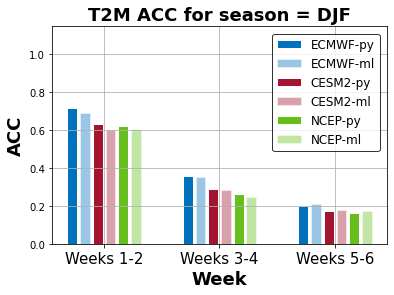

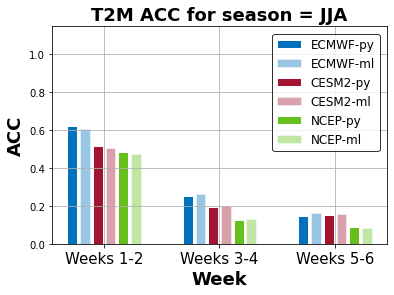

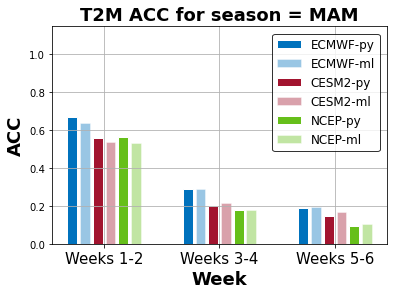

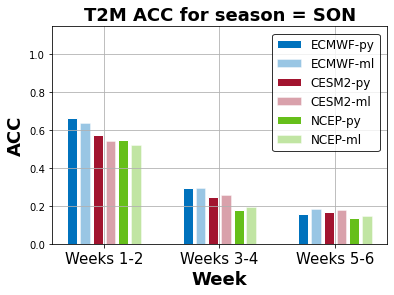

In [20]:
seasons = np.array(weight.season)
barWidth = 0.085
rw = np.arange(3)
rw_s = [x + barWidth + 0.025 for x in rw]
rw1 = [x + barWidth + 0.025 for x in rw_s]
rw1_s = [x + barWidth + 0.025 for x in rw1]
rw2 = [x + barWidth + 0.025 for x in rw1_s]
rw2_s = [x + barWidth + 0.025 for x in rw2]

if weight.min() < 0.:
    ymin = weight.min()*0.6+weight.min()
else:
    ymin = 0.0
ymax = weight.max()*0.6+weight.max()
#ymax = weight.max()*1.0+weight.max()
for s in seasons:
    plt.bar(rw,weight.sel(season=s,model=models[0]), width = barWidth, color = (0, 0.4470, 0.7410), edgecolor="white",label=models[0]+"-py")
    plt.bar(rw_s,weight2.sel(season=s,model=models[0]), width = barWidth, color = (0, 0.4470, 0.7410), alpha=0.4, edgecolor="white",label=models[0]+"-ml")
    plt.bar(rw1,weight.sel(season=s,model=models[2]), width = barWidth, color = (0.6350, 0.0780, 0.1840), edgecolor="white",label=models[2]+"-py")
    plt.bar(rw1_s,weight2.sel(season=s,model=models[2]), width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.4, edgecolor="white",label=models[2]+"-ml")
    plt.bar(rw2,weight.sel(season=s,model=models[1]), width = barWidth, color = (0.4, .75, 0.1),edgecolor="white",label=models[1]+"-py")
    plt.bar(rw2_s,weight2.sel(season=s,model=models[1]), width = barWidth, color = (0.4, .75, 0.1), alpha=0.4,edgecolor="white",label=models[1]+"-ml")
    plt.xticks([r + barWidth + 0.189 for r in range(3)], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
    plt.ylim(ymin,ymax)
    plt.ylabel(metric.upper(),fontsize=18,fontweight="bold")
    plt.xlabel("Week",fontsize=18,fontweight="bold")
    plt.grid()
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 12},loc="upper right")
    #plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 12},loc="upper left")
    plt.title(variable.upper()+" "+metric.upper()+" for season = "+s,fontsize=18,fontweight="bold")
    plt.savefig(metric+"_"+variable+"_globalland_"+s+"_weights.jpg",dpi=300,bbox_inches="tight")
    plt.show()

## TESTING TO FIND ISSUE WITH WEIGHTING

Here we want to do a test starting with making the data only vary longitudinally

In [17]:
met_seas_all = (met_seas_all*0)+0.66+np.cos(np.deg2rad(met_seas_all.lon))

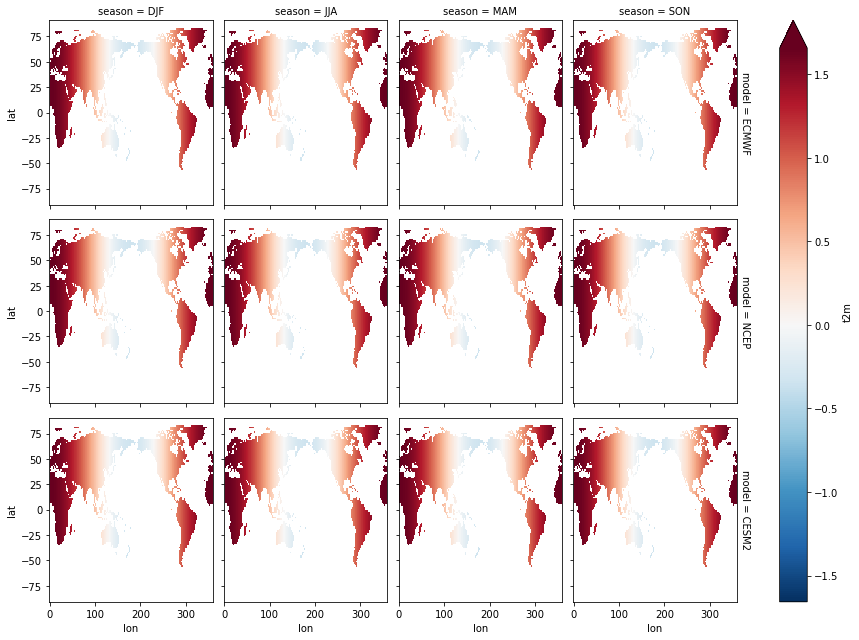

In [18]:
met_seas_all.sel(lead=15)[variable].plot(col=groupby, row='model', robust=True)

In [19]:
test = met_seas_all.t2m.sel(lead=1,season="DJF",model="CESM2").squeeze()

Looking at the zonal mean of one model/season/lead.

In [20]:
np.nanmean(test,axis=1)

array([       nan,        nan,        nan,        nan,        nan,
       1.2636105 , 1.16605865, 1.20360396, 1.13392561, 0.97989752,
       0.80175536, 0.78330177, 0.68640262, 0.62491856, 0.48777141,
       0.49278982, 0.50902176, 0.52175095, 0.50036477, 0.50776755,
       0.55114303, 0.66749288, 0.6957304 , 0.71362457, 0.77458936,
       0.80891921, 0.81973576, 0.8037077 , 0.83626559, 0.81751155,
       0.81511734, 0.77418771, 0.78962131, 0.83824648, 0.83773629,
       0.82896166, 0.77159402, 0.80253916, 0.83612385, 0.91632134,
       0.98297614, 1.02123481, 1.0293899 , 1.06402479, 1.07009731,
       1.11623306, 1.17875885, 1.20346846, 1.18845819, 1.22253901,
       1.2609118 , 1.28410389, 1.29997673, 1.30885461, 1.30494672,
       1.30653728, 1.31829402, 1.22316927, 1.22361518, 1.12276463,
       1.09047603, 1.05599503, 0.97080897, 1.01456835, 1.11262235,
       1.02904885, 1.11412629, 1.2927345 , 1.20958777, 1.1805279 ,
       1.0883096 , 1.03330158, 0.95534314, 0.92156105, 0.84366

The next cell is based on an idea Judith had. We wanted to do the zonal average after the cosine weighting
instead of before to see what happens. Here I am just printing the cosine weighted zonal means before averaging

In [21]:
MET0 = met_seas_all.t2m.sel(lead=1,season="DJF",model="CESM2").squeeze()
lat = met_seas_all.lat
MET0 = MET0.where(lmask==False)
MET0 = MET0.where(np.isfinite(MET0))
#METzm = np.nanmean(MET0,axis=1)
nanmask=~np.isnan(MET0)
#met_new = np.nansum(MET0*np.cos(np.deg2rad(lat)))/np.nansum(nanmask*np.cos(np.deg2rad(lat)))
met_new = nanmask*np.cos(np.deg2rad(lat))
met_new = np.nanmean(met_new,axis=1)
dm_j = xr.DataArray(met_new)
dm_j

<xarray.DataArray (dim_0: 121)>
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01631577, 0.04236767, 0.04783683, 0.05111162, 0.06322479,
       0.08088095, 0.09230499, 0.12875708, 0.17246688, 0.25085756,
       0.29498515, 0.33386299, 0.33902749, 0.33292637, 0.32407032,
       0.32291667, 0.29390544, 0.29955147, 0.31624348, 0.35267115,
       0.37793939, 0.37497007, 0.37343263, 0.39311423, 0.37859502,
       0.37712362, 0.36873197, 0.34989736, 0.36752955, 0.34971568,
       0.34378645, 0.34383222, 0.34681977, 0.34245715, 0.36592474,
       0.38610299, 0.36983553, 0.36754019, 0.3497518 , 0.33877311,
       0.33875583, 0.31119348, 0.28672012, 0.29324243, 0.27566067,
       0.24550615, 0.23904094, 0.2160076 , 0.24581373, 0.25103745,
       0.25199224, 0.21962359, 0.2243064 , 0.19972591, 0.22075766,
       0.23333333, 0.25407957, 0.27878408, 0.25753698, 0.23619895,
       0.25612326, 0.23046061, 0.19255409, 0.19155391, 0.20662861,
       0.221358  , 0.23570985, 0.22983866, 0.21994968, 0.23728503,
       0.23481938, 0.22077349, 0.21060323, 0.19676394, 0.19041037,
       0.17681352, 0.1634227 , 0.13278951, 0.09614806, 0.06404718,
       0.05619586, 0.02590487, 0.02534687, 0.02477149, 0.02115675,
       0.01767767, 0.01434072, 0.01951631, 0.01353017, 0.01048867,
       0.01014602, 0.00734732, 0.00472005, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])
Dimensions without coordinates: dim_0

Here we are looking at Sasha's method. Looking at the denominator with the nanmask calculated
before the cosine weighting

In [22]:
MET0 = met_seas_all.t2m.sel(lead=1,season="DJF",model="CESM2").squeeze()
lat = met_seas_all.lat
MET0 = MET0.where(lmask==False)
MET0 = MET0.where(np.isfinite(MET0))
METzm = np.nanmean(MET0,axis=1)
nanmask=~np.isnan(METzm)
#met_new = np.nansum(METzm*np.cos(np.deg2rad(lat)))/np.nansum(nanmask*np.cos(np.deg2rad(lat)))
met_new = nanmask*np.cos(np.deg2rad(lat))
#met_new = np.nanmean(met_new,axis=1)
#met_new = np.nansum(METzm*np.cos(np.deg2rad(lat)))/np.nansum(nanmask)
dm_s = xr.DataArray(met_new)
dm_s

<xarray.DataArray 'lat' (lat: 121)>
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.13052619, 0.15643447, 0.18223553, 0.20791169, 0.23344536,
       0.25881905, 0.28401534, 0.30901699, 0.33380686, 0.35836795,
       0.38268343, 0.40673664, 0.4305111 , 0.4539905 , 0.47715876,
       0.5       , 0.52249856, 0.54463904, 0.56640624, 0.58778525,
       0.60876143, 0.62932039, 0.64944805, 0.66913061, 0.68835458,
       0.70710678, 0.72537437, 0.74314483, 0.76040597, 0.77714596,
       0.79335334, 0.80901699, 0.82412619, 0.83867057, 0.85264016,
       0.8660254 , 0.87881711, 0.89100652, 0.90258528, 0.91354546,
       0.92387953, 0.93358043, 0.94264149, 0.95105652, 0.95881973,
       0.96592583, 0.97236992, 0.9781476 , 0.98325491, 0.98768834,
       0.99144486, 0.9945219 , 0.99691733, 0.99862953, 0.99965732,
       1.        , 0.99965732, 0.99862953, 0.99691733, 0.9945219 ,
       0.99144486, 0.98768834, 0.98325491, 0.9781476 , 0.97236992,
       0.96592583, 0.95881973, 0.95105652, 0.94264149, 0.93358043,
       0.92387953, 0.91354546, 0.90258528, 0.89100652, 0.87881711,
       0.8660254 , 0.85264016, 0.83867057, 0.82412619, 0.80901699,
       0.79335334, 0.77714596, 0.76040597, 0.74314483, 0.72537437,
       0.70710678, 0.68835458, 0.66913061, 0.64944805, 0.62932039,
       0.60876143, 0.58778525, 0.56640624, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])
Coordinates:
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
    skill    <U11 'initialized'

Next, we compare them plotted. The first (dm_j, Judith's method) shows latitudinal variation
based on the land mask. Sasha's (dm_s) shows a normal distribution with the max at equator.

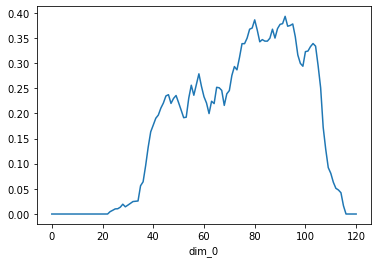

In [46]:
dm_j[::-1].plot()

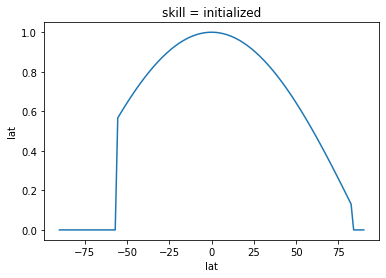

In [24]:
dm_s.plot()